### This notebook uses some new library functions in the a405dropgrow package to find equilibrium drop sizes

In [25]:
import a405dropgrow.aerolib
from importlib import reload
reload(a405dropgrow.aerolib)
#
# new library for aerosol functions
#
from a405dropgrow.aerolib import lognormal,create_koehler,find_koehler_coeffs
import numpy as np
import a405utils.helper_funs
reload(a405utils.helper_funs)
from a405utils.helper_funs import make_tuple, find_centers
from a405thermo.rootfinder import find_interval, fzero
import ruamel.yaml as ry  #need to pip install ruamel.yaml
import pprint
pp = pprint.PrettyPrinter(indent=4)
#
# find the path to the data folder.  We know it's
# at the same level as a405utils, so construct
# the path relative to the location of the a405utils folder
#
from pathlib import Path
util_dir, = a405utils.__path__._path
data_dir = Path(util_dir).joinpath('../data')

### Read in the inital conditions

Use the [yaml](https://en.wikipedia.org/wiki/YAML) file format to specify
aerosol properties and initial conditions as a nested dictionary with
comments

In [26]:
yaml_file = data_dir.joinpath('dropgrow.yaml')
with yaml_file.open('r') as f:
    input_dict=ry.load(f,Loader=ry.RoundTripLoader)
pp.pprint(input_dict)

CommentedOrderedMap([   (   'initial_conditions',
                            CommentedOrderedMap([   ('Tinit', 280.0),
                                                    ('Zinit', 1000.0),
                                                    ('Pinit', 90000.0),
                                                    ('Sinit', 0.995),
                                                    ('wvel', 0.5)])),
                        (   'aerosol',
                            CommentedOrderedMap([   ('Ms', 114),
                                                    ('Mw', 18.0),
                                                    ('Sigma', 0.075),
                                                    ('vanHoff', 2.0),
                                                    ('rhoaero', 1775),
                                                    ('themean', 2e-17),
                                                    ('sd', 1.7),
                                                    ('totmass', 1.5e-09)]))])


### Calculate the lognormal aerosol mass distribution and get the number concentration in each of 30 bins

(code borrowed from aero.ipynb)

In [27]:
mass_vals = np.linspace(-20,-16,30)
mass_vals = 10**mass_vals
mu=input_dict['aerosol']['themean']
sigma = input_dict['aerosol']['sd']
totmass = input_dict['aerosol']['totmass']
mdist = totmass*lognormal(mass_vals,np.log(mu),np.log(sigma))
mdist = find_centers(mdist)*np.diff(mass_vals)
center_mass = find_centers(mass_vals)
ndist = mdist/center_mass

### Find the equilibrium radius for each of the 30 aerosol masses

(code borrowed from koehler.ipynb)

### Python note -- using function factories ("closures")

A closure is a function object that remembers values in its  "enclosing scope" 
(see e.g [this article](http://www.shutupandship.com/2012/01/python-closures-explained.html)).  For example, instead of
writing:

```python
my_string = "{:8.3g}".format(value)
```
    
every time we wanted to format a floating point number, we could do something like this:

In [28]:
def make_format(format_string="{:8.3g}"):
    """
    returns a function that formats with format_string
    """
    def inner_fun(value):
        return format_string.format(value)
    return inner_fun

#Now get closures from make_format and use it:

g = make_format()
info = make_format(format_string="debugging {}")

a=10
b=1.546e-23
print(info(a), g(b))


debugging 10 1.55e-23


### Calculating the equilibrium size distribution for unactivated aerosols

Below we use 

In [29]:
aero=make_tuple(input_dict['aerosol'])
parcel=make_tuple(input_dict['initial_conditions'])

a, b = find_koehler_coeffs(aero,parcel)

#
# sanity check
#
m=1.e-18
Scrit=(4.*a**3./(27.*b*m))**0.5;
rcrit = (3.*m*b/a)**0.5
print(("for aerosol with mass = {} kg, "
       "SScrit,rcrit are {:8.3g}, {:8.3g} microns")
        .format(m,Scrit,rcrit*1.e6))


for aerosol with mass = 1e-18 kg, SScrit,rcrit are  0.00175,    0.441 microns


mass = 1.19e-20 kg
left bracket = 9.490e-03 microns
right bracket=1.905e-01 microns
critical supersaturation: 0.0161
equlibrium radius at S=0.995 is 0.026 microns

mass = 1.63e-20 kg
left bracket = 9.490e-03 microns
right bracket=1.905e-01 microns
critical supersaturation: 0.0137
equlibrium radius at S=0.995 is 0.030 microns

mass = 2.24e-20 kg
left bracket = 9.490e-03 microns
right bracket=1.905e-01 microns
critical supersaturation: 0.0117
equlibrium radius at S=0.995 is 0.035 microns

mass = 3.08e-20 kg
left bracket = 3.600e-02 microns
right bracket=1.640e-01 microns
critical supersaturation: 0.00999
equlibrium radius at S=0.995 is 0.041 microns

mass = 4.23e-20 kg
left bracket = 3.600e-02 microns
right bracket=1.640e-01 microns
critical supersaturation: 0.00853
equlibrium radius at S=0.995 is 0.047 microns

mass = 5.81e-20 kg
left bracket = 5.475e-02 microns
right bracket=1.453e-01 microns
critical supersaturation: 0.00727
equlibrium radius at S=0.995 is 0.055 microns

mass = 7.98e-

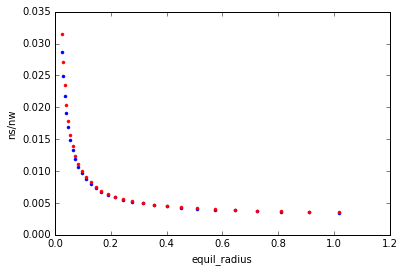

In [37]:
%matplotlib inline
koehler_fun = create_koehler(aero,parcel)

def find_diff(r,S_target,m):
    """
    zero function for rootfinder
    """
    return S_target - koehler_fun(r,m)

S_target = parcel.Sinit
r_start = 0.1e-6

fig,ax = plt.subplots(1,1)
ax.set(xlabel = 'equil_radius',ylabel = 'ns/nw')


initial_radius = []
for mass in center_mass:
    brackets = np.array(find_interval(find_diff,r_start,S_target,mass))
    left_bracket, right_bracket = brackets*1.e6  #get brackets in microns for printing
    equil_rad = fzero(find_diff,brackets,S_target,mass)
    
    Scrit=(4.*a**3./(27.*b*mass))**0.5
    vanHoff = input_dict['aerosol']['vanHoff']
    Ms = input_dict['aerosol']['Ms']
    rhoaero = input_dict['aerosol']['rhoaero']
    Mw = input_dict['aerosol']['Mw']
    
    ns = mass*vanHoff/Ms
    nw = 4/3.*np.pi*equil_rad**3.*rhoaero /Mw
    
    nw_2 = (4/3.*np.pi*equil_rad**3. - mass/rhoaero)*rhoaero /Mw
    ax.plot(equil_rad* 1.e6,ns/nw,'.b') #exact
    ax.plot(equil_rad* 1.e6,ns/nw_2,'.r') #approx
   
    
    initial_radius.append(equil_rad)
    print(('mass = {mass:6.3g} kg\n'
           'left bracket = {left_bracket:8.3e} microns\n'
           'right bracket={right_bracket:8.3e} microns\n'
           'critical supersaturation: {Scrit:6.3g}')
           .format_map(locals()))
    print('equlibrium radius at S={} is {:5.3f} microns\n'.format(S_target,equil_rad*1.e6))
   
